In [ ]:
# Based on original iTEBD-example.ipynb from https://github.com/val-link/iTEBD-TEMPO.git by Valentin Link
# Adapted to do a simple simulation using OQuPy, and using a modified iTEBD-TEMPO code which uses OQuPy's BathCorrelations class by Paul Eastham


In [1]:
import oqupy as oqupy

In [2]:
from oqupy.iTEBD_TEMPO import iTEBD_TEMPO
from oqupy.iTEBD_TEMPO_useoqupybath import iTEBD_TEMPO_oqupy

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import qutip as qt

In [4]:
sigma_z = oqupy.operators.sigma("z")
omega_cutoff = 3.04 
alpha = 0.126
temperature = 0.1309
correlations = oqupy.PowerLawSD(alpha=alpha,
                                zeta=3,
                                cutoff=omega_cutoff,
                                cutoff_type='gaussian',
                                temperature=temperature)
bath = oqupy.Bath(sigma_z/2.0, correlations)



In [5]:
# uses a modified version of Link's iTEBD_TEMPO class, which will take the bath correlation defined in OQuPy
# other parameters remain as in the original, i.e. eigenvalues of the coupling operator, timestep, cut-off.
Delta=0.1
MyiTEBD_TEMPO_oqupy = iTEBD_TEMPO_oqupy(np.diagonal(sigma_z/2), Delta, correlations, 100)

In [6]:
MyiTEBD_TEMPO_oqupy.compute_f(rank=100, rtol=1e-7) 

building influence functional:   0%|          | 0/100 [00:00<?, ?it/s]C:\Users\preas\AppData\Local\Temp\ipykernel_20276\1890049501.py:1: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  MyiTEBD_TEMPO_oqupy.compute_f(rank=100, rtol=1e-7)
building influence functional: 100%|██████████| 100/100 [00:00<00:00, 279.29it/s]

rank  83


In [7]:
# time evolution using iTEBD
H_S=0.0*oqupy.operators.sigma('z') # free Hamiltonian
Rho_0=oqupy.operators.spin_dm('x+')
N=200
Rho_t = MyiTEBD_TEMPO_oqupy.evolve(H_S, Rho_0, N)

time evolution running: 100%|██████████| 200/200 [00:00<00:00, 1087.98it/s]


In [8]:
# let's do it using OQuPy
sigma_x = oqupy.operators.sigma("x")
sigma_y = oqupy.operators.sigma("y")
sigma_z = oqupy.operators.sigma("z")
tempo_parameters = oqupy.TempoParameters(dt=Delta, epsrel=10**(-7),dkmax=100)

process_tensor = oqupy.pt_tempo_compute(bath=bath,
                                        start_time=0.0,
                                        end_time=Delta*N,
                                        parameters=tempo_parameters)

--> PT-TEMPO computation:
100.0%  200 of  200 [########################################] 00:01:06
Elapsed time: 67.0s


In [9]:
def hamiltonian_t(t):
    return 0.0 * sigma_z

system = oqupy.TimeDependentSystem(hamiltonian_t)
dynamics = oqupy.compute_dynamics(
       process_tensor=process_tensor,        
       system=system,
       initial_state=Rho_0,
       start_time=0.0)
t, s_x = dynamics.expectations(sigma_x, real=True)
_, s_y = dynamics.expectations(sigma_y, real=True)
_, s_z = dynamics.expectations(sigma_z, real=True)


--> Compute dynamics:
100.0%  200 of  200 [########################################] 00:00:05
Elapsed time: 5.0s


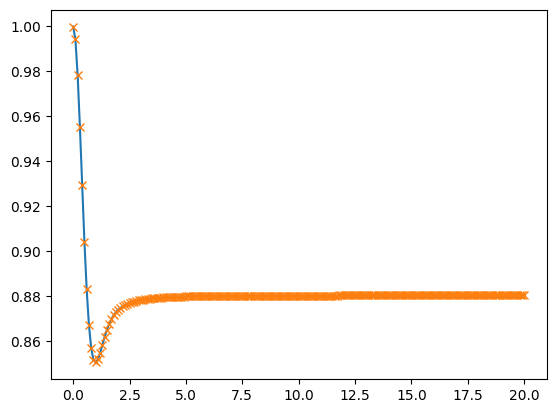

In [20]:
T_eval = np.linspace(0, N * Delta, N + 1)
j=0.5
plt.plot(T_eval,np.einsum('ij,tji->t', qt.operators.jmat(j,'x').full(), Rho_t).real/ j)
plt.plot(t,s_x,'x')